In [76]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 621 (delta 166), reused 143 (delta 89), pack-reused 393 (from 1)
Receiving objects: 100% (621/621), 30.17 MiB | 12.24 MiB/s, done.
Resolving deltas: 100% (424/424), done.
/content/ELENA/ELENA/ELENA


In [77]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [78]:
%%writefile /content/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

# Entropy density of the SM plasma (approximate, constant g_star)
g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Overwriting /content/utils.py


In [79]:
%%writefile /content/ELENA/src/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Overwriting /content/ELENA/src/utils.py


In [80]:
from google.colab import files
uploaded = files.upload()



Saving ah_pot.m to ah_pot.m


In [81]:
#!/usr/bin/env python3
"""
Generic converter from a Mathematica DRalgo-style potential

    V[field_, T_] := expr

to a Python module potential_3d.py with

    def V(phi, T)
    def dV(phi, T)

that is numerically stable and ELENA-compatible.

- Works for ANY thermal potential with one scalar field and temperature T.
- Automatically detects all other symbols as parameters that must be provided
  by get_params(T).

Usage:
  1. Put your Mathematica definition (one line) into INPUT_FILE
     e.g.:
       V[phi_, T_] := (msq*ϕ^2)/2 + (λ*ϕ^4)/4 - ...

  2. Run:
       python generate_potential_generic.py

  3. You get `potential_3d.py`. Open it and implement get_params(T).
"""

import sympy as sp
from pathlib import Path
import re

# You already set this:
INPUT_FILE  = "ah_pot.m"
OUTPUT_FILE = "potential_3d.py"


# ------------------------------------------------------------------
# Helpers: Mathematica → SymPy-friendly string
# ------------------------------------------------------------------

# Common symbol name mappings used by DRalgo / SM / BSM models
MMA_SYMBOL_MAP = {
    # Field aliases (Unicode & escaped forms)
    "ϕ": "phi",
    "φ": "phi",
    "\\[CurlyPhi]": "phi",
    "\\[Phi]": "phi",

    # Lambdas
    "λ": "lam",
    "\\[Lambda]": "lam",
    "\\[Lambda]1H": "lam1H",

    # Mus / renormalisation scales
    "μ3US": "mu3US",
    "\\[Mu]3US": "mu3US",
    "\\[Mu]": "mu",

    # Hypercharges / generic charges / angles
    "Yϕ": "Yphi",
    "\\[Alpha]": "alpha",
    "\\[Beta]": "beta",

    # Standard Mathematica builtins
    "Pi": "pi",
    "Sqrt": "sqrt",
    "Log": "log",
}


def extract_def_line(mathematica_str: str):
    """
    Find the last definition line of the form

        V[field_, T_] := expr

    and return:

        field_name, T_name, rhs_string

    with field_name / T_name stripped of underscores.
    """
    lines_with_def = [ln for ln in mathematica_str.splitlines() if ":=" in ln]
    if not lines_with_def:
        raise ValueError("Could not find ':=' in input file.")

    last = lines_with_def[-1]

    # Extract the part between 'V[' and ']:='
    try:
        inside = last.split("V[", 1)[1].split("]:=", 1)[0]
    except IndexError as e:
        raise ValueError(
            "Could not parse the V[field_, T_] definition line. "
            "Make sure it has the form 'V[phi_, T_] := ...'."
        ) from e

    # Split arguments: e.g. "phi_, T_" -> "phi_", "T_"
    parts = [p.strip() for p in inside.split(",")]
    if len(parts) != 2:
        raise ValueError(
            f"Expected two arguments in V[...], found: {inside!r}"
        )

    field_part, T_part = parts
    field_name = field_part.replace("_", "").strip()
    T_name     = T_part.replace("_", "").strip()

    rhs = last.split(":=", 1)[1].strip()
    return field_name, T_name, rhs


def mathematica_to_sympy(expr: str) -> str:
    """
    Generic textual conversion from Mathematica syntax to something SymPy can parse.
    Handles:
      - greek / escaped letters like ϕ, \\[CurlyPhi], λ, \\[Lambda]1H, μ3US, \\[Mu]3US
      - Pi, Sqrt, Log
      - power ^ to **
      - [ ] to ( )
    Everything else is left untouched so it's model-agnostic.
    """
    # Symbol-level replacements
    for old, new in MMA_SYMBOL_MAP.items():
        expr = expr.replace(old, new)

    # Structural replacements
    expr = expr.replace("^", "**")
    expr = expr.replace("[", "(")
    expr = expr.replace("]", ")")
    return expr


def make_half_powers_safe(expr: sp.Expr) -> sp.Expr:
    """
    Replace half-integer powers x^(n/2) with Abs(x)^(n/2) to avoid complex/NaN
    when x is slightly negative due to numerics.

    This catches things like (msq + lam*phi**2)**(3/2), ( ... )**(1/2), etc.
    """

    def repl_pow(e):
        if isinstance(e, sp.Pow) and isinstance(e.exp, sp.Rational) and e.exp.q == 2:
            # e.base**(m/2)  ->  Abs(e.base)**(m/2)
            return sp.Pow(sp.Abs(e.base), e.exp)
        return e

    return expr.replace(
        lambda e: isinstance(e, sp.Pow)
        and isinstance(e.exp, sp.Rational)
        and e.exp.q == 2,
        repl_pow,
    )


def sympy_to_numpy_code(expr: sp.Expr) -> str:
    """
    Convert SymPy expression to a Python/NumPy-friendly code string.
    - uses sympy.pycode
    - then replaces sqrt/log/pi/Abs with safe NumPy wrappers
    """
    code = sp.pycode(expr)  # e.g. sqrt(...), log(...), pi, Abs(...)

    # sqrt -> _rtabs (numerically safe absolute sqrt)
    code = re.sub(r"\bsqrt\(", "_rtabs(", code)

    # log -> _logsafe (numerically safe log)
    code = re.sub(r"\blog\(", "_logsafe(", code)

    # pi -> np.pi
    code = re.sub(r"\bpi\b", "np.pi", code)

    # Abs -> np.abs
    code = re.sub(r"\bAbs\(", "np.abs(", code)

    return code


# ------------------------------------------------------------------
# Main generator
# ------------------------------------------------------------------

def main():
    # 1. Read Mathematica potential
    src = Path(INPUT_FILE).read_text(encoding="utf-8")

    # Extract field / T names and RHS of the potential
    field_name_raw, T_name_raw, rhs_raw = extract_def_line(src)
    rhs_sympy_like = mathematica_to_sympy(rhs_raw)

    # 2. Build SymPy expression
    # We *canonicalise* the Python interface to use 'phi' and 'T'
    phi, T = sp.symbols("phi T", real=True)

    # Let SymPy create symbols for anything else automatically.
    # Map both the original Mathematica argument names and the
    # canonical names so it works whether rhs uses 'phi' or '\\[CurlyPhi]'.
    local_map = {
        field_name_raw: phi,
        T_name_raw: T,
        "phi": phi,
        "T": T,
        "sqrt": sp.sqrt,
        "log": sp.log,
        "pi": sp.pi,
    }

    V_expr = sp.sympify(rhs_sympy_like, locals=local_map)

    # 2b. Make all half-integer powers sqrt-safe
    V_expr = make_half_powers_safe(V_expr)

    # 3. Find all free parameters (symbols) except phi and T
    free_syms = V_expr.free_symbols
    free_syms = sorted(free_syms, key=lambda s: s.name)
    param_syms = [s for s in free_syms if s not in (phi, T)]

    param_names = [s.name for s in param_syms]
    param_names_str = ", ".join(param_names) if param_names else "(none)"

    # Some light classification (just for the header)
    gauge_like   = [n for n in param_names if n.startswith("g")]
    quartic_like = [n for n in param_names if n.startswith("lam")]
    mass_like    = [n for n in param_names if n.startswith("m") or n.endswith("2")]

    # 4. Convert expression to NumPy-friendly string
    V_numpy = sympy_to_numpy_code(V_expr)

    # 5. Build the potential_3d.py text
    header = f'''"""
Auto-generated potential_3d.py from Mathematica DRalgo output.

Original definition:
    V[{field_name_raw}_, {T_name_raw}_] := ...

Python interface:
    V(phi, T)  — one-field 3D effective potential (thermal or not)
    dV(phi, T) — finite-difference derivative wrt phi

Detected free parameters (besides phi, T):
    {param_names_str}

Rough classification:
    - gauge-like:   {", ".join(gauge_like)   or "none detected"}
    - quartic-like: {", ".join(quartic_like) or "none detected"}
    - mass-like:    {", ".join(mass_like)    or "none detected"}

You MUST implement get_params(T) below to provide numerical values
for these parameters at any given temperature T.

Typical usage in ELENA:
    from potential_3d import V, dV
"""

import numpy as np

# ---------- numerically safe helpers ----------

def _rtabs(x, floor=1e-30):
    \"\"\"sqrt(|x|) with a floor to avoid NaNs from tiny negatives.\"\"\"
    x = np.asarray(x, dtype=float)
    return np.sqrt(np.maximum(np.abs(x), floor))

def _logsafe(x, floor=1e-30):
    \"\"\"log(|x|) with a floor to avoid log(0) / log(negative) issues.\"\"\"
    x = np.asarray(x, dtype=float)
    return np.log(np.maximum(np.abs(x), floor))


def get_params(T):
    \"\"\"
    USER MUST IMPLEMENT.

    Given a temperature T (float), return a dict mapping parameter names to values.
    Required keys:
        {param_names_str}

    Example:
        return dict(msq=..., lam=..., gw=..., gY=..., mu3US=...)
    \"\"\"
    raise NotImplementedError(
        "Implement get_params(T) so that it returns a dict with keys: {param_names_str}"
    )

'''

    # parameter extraction inside V
    if param_names:
        param_extract_lines = [
            f"    {name} = params['{name}']"
            for name in param_names
        ]
    else:
        param_extract_lines = ["    # no extra parameters"]
    param_extract_code = "\n".join(param_extract_lines)

    V_def = f'''
def V(phi, T):
    \"\"\"3D effective potential V(phi, T) translated from Mathematica.\"\"\"
    phi = np.asarray(phi, dtype=float)
    T = float(T)

    params = get_params(T)
{param_extract_code}

    return {V_numpy}
'''

    dV_def = r'''
def dV(phi, T, h_rel=1e-3, h_abs=1e-5):
    """
    Numerical derivative dV/dphi via symmetric finite differences.
    Works for scalar phi or NumPy arrays of phi.
    """
    phi = np.asarray(phi, dtype=float)
    T = float(T)

    h = h_rel * np.maximum(np.abs(phi), 1.0) + h_abs
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)
'''

    out_text = header + V_def + dV_def
    Path(OUTPUT_FILE).write_text(out_text, encoding="utf-8")
    print(f"Wrote {OUTPUT_FILE} with generic V(phi,T) and dV(phi,T).")
    print("Free parameters:", param_names_str)


if __name__ == "__main__":
    main()


Wrote potential_3d.py with generic V(phi,T) and dV(phi,T).
Free parameters: Yphi, g1, lam, msq, mu3US


In [82]:
from pathlib import Path

# 1. Load the current potential_3d.py
path = Path("potential_3d.py")
text = path.read_text()

# 2. New full definition of get_params(T)
new_get_params = """
def get_params(T):
    \"""
    4D → 3D matching for Abelian Higgs model (example / placeholder).

    Returns a dict with keys:
        Yphi, g1, lam, msq, mu3US
    \"""
    T = float(T)

    # ---- 4D input couplings (set these to your DRalgo values) ----
    g1_4   = 0.54
    lam_4  = 1.65e-3
    m0sq_4 = -(130.0**2)
    Yphi_4 = 1.0

    # ---- Simple DR-like matching (you can refine later) ----
    g1sq_3 = (g1_4**2) * T                  # 3D gauge coupling squared
    lam_3  = lam_4 * T                      # 3D quartic
    msq_3  = m0sq_4 + (0.30*(g1_4**2) + 0.10*lam_4) * T*T
    mu3US  = max(g1_4 * T, 1.0)             # 3D renormalisation scale

    # Convert g1^2 → g1 for the potential
    g1_3 = np.sqrt(g1sq_3)
    Yphi = Yphi_4

    return dict(
        Yphi=Yphi,
        g1=g1_3,
        lam=lam_3,
        msq=msq_3,
        mu3US=mu3US,
    )
"""

# 3. Replace everything from 'def get_params(T):' up to the next 'def V('
start = text.index("def get_params(T):")
end   = text.index("def V(", start)   # assume V is the next function after get_params

new_text = text[:start] + new_get_params + "\n\n" + text[end:]

# 4. Write patched file
path.write_text(new_text)



7745

In [83]:

import re
from pathlib import Path

path = Path("potential_3d.py")
text = path.read_text()

# Remove all math. prefixes
text = text.replace("math._rtabs", "_rtabs")
text = text.replace("math._logsafe", "_logsafe")
text = text.replace("math.np.pi", "np.pi")
text = text.replace("math.", "")   # remove any leftover math.

# Clean accidental double prefixes
text = text.replace("np.np", "np")

# Write cleaned file
path.write_text(text)



7380

In [84]:
%%writefile custom_model.py
from potential_3d import V as V_raw, dV as dV_raw

class CustomModel:
    """
    Minimal drop-in replacement for `model`:
    exposes DVtot and gradV, wrapping your custom V and dV.
    """
    def __init__(self, vev, lambda_, g, xstep, Tstep, units="MeV"):
        self.vev     = vev
        self.lambda_ = lambda_
        self.g       = g
        self.xstep   = xstep
        self.Tstep   = Tstep
        self.units   = units

        # If you want rescaling by units, do it here.
        # For now: just pass through to your potential.
        self.DVtot = lambda phi, T: V_raw(phi, T)
        self.gradV = lambda phi, T: dV_raw(phi, T)


Writing custom_model.py


In [85]:
import numpy as np
from utils import convert_units
from custom_model import CustomModel  # instead of `from model import model`

# You can still choose units randomly if you like
units = np.random.choice(list(convert_units.keys()))

# Parameters
lambda_ = 1.65e-3
g       = 0.54
vev, units = 500, "MeV"
description = "Fast"

# Construct "model" using your custom potential
dp = CustomModel(vev, lambda_, g,
                 xstep = vev * 1e-3,
                 Tstep = vev * 1e-3,
                 units = units)

V  = dp.DVtot   # this now points to your big V(phi,T)
dV = dp.gradV   # this now points to your big dV(phi,T)

print(f"lambda = {lambda_}")
print(f"g      = {g}")
print(f"vev    = {vev} {units}")


phi_test = 10.0
T_test   = 150.0
print("V(10, 150) =", V(phi_test, T_test))
print("dV(10, 150) =", dV(phi_test, T_test))


lambda = 0.00165
g      = 0.54
vev    = 500 MeV
V(10, 150) = -843463.6121643414
dV(10, 150) = -152450.76936889338


/content/ELENA/potential_3d.py:88: RuntimeWarning: invalid value encountered in divide
  return (1/16)*Yphi**2*g1**2*abs(phi)*_rtabs(abs(Yphi**2*g1**2))*_rtabs(abs(lam*phi**2 + msq))/np.pi**2 + (1/16)*Yphi**2*g1**2*abs(phi)*_rtabs(abs(Yphi**2*g1**2))*_rtabs(abs(3*lam*phi**2 + msq))/np.pi**2 - 1/16*lam**2*phi**2*(_logsafe(mu3US/(2*_rtabs(abs(lam*phi**2 + msq)) + _rtabs(abs(3*lam*phi**2 + msq)))) + 1/2)/np.pi**2 - 3/16*lam**2*phi**2*(_logsafe((1/3)*mu3US/_rtabs(abs(3*lam*phi**2 + msq))) + 1/2)/np.pi**2 + (1/4)*lam*phi**4 + (3/64)*lam*(lam*phi**2 + msq)/np.pi**2 + (3/64)*lam*(3*lam*phi**2 + msq)/np.pi**2 + (1/32)*lam*_rtabs(abs(lam*phi**2 + msq))*_rtabs(abs(3*lam*phi**2 + msq))/np.pi**2 + (1/2)*msq*phi**2 - 1/6*phi**2*abs(phi)*abs(Yphi**2*g1**2)**(3/2)/np.pi - 1/12*abs(lam*phi**2 + msq)**(3/2)/np.pi - 1/12*abs(3*lam*phi**2 + msq)**(3/2)/np.pi + (1/4)*((1/4)*lam**2*phi**4*(_logsafe(mu3US/(_rtabs(abs(lam*phi**2 + msq)) + _rtabs(abs(3*lam*phi**2 + msq)))) + 1/2)/np.pi**2 - 1/16*(Yphi**2*g1**

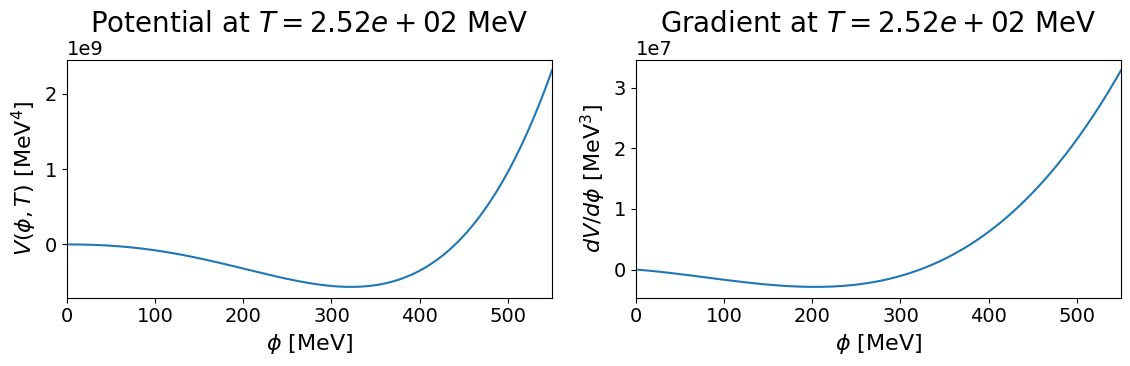

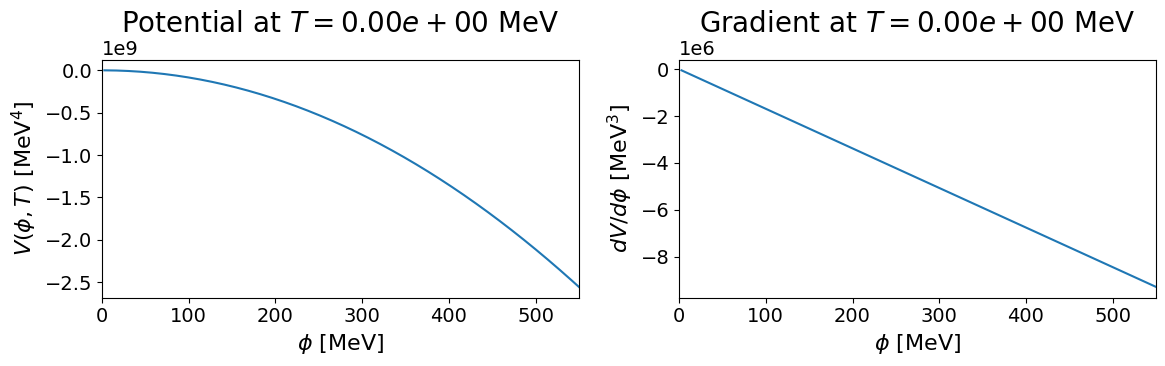

In [125]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=SyntaxWarning)

# Set global font size parameters
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20,
    'text.usetex': False    # <<< IMPORTANT for Colab
})

T = np.random.uniform(0, 3*vev)

phi = np.linspace(0, 1.1 * vev, 200)
phi = phi.reshape(-1,1)

for t in [T, 0]:
    v = V(phi, t)
    dv = dV(phi, t)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(phi, v)
    axes[0].set_title(f"Potential at $T = {t:.2e}$ {units}")
    axes[0].set_xlabel(f"$\\phi$ [{units}]")
    axes[0].set_ylabel(f"$V(\\phi, T)$ [{units}$^4$]")

    axes[1].plot(phi[1:], dv[1:])
    axes[1].set_title(f"Gradient at $T = {t:.2e}$ {units}")
    axes[1].set_xlabel(f"$\\phi$ [{units}]")
    axes[1].set_ylabel(f"$dV/d\\phi$ [{units}$^3$]")

    for ax in axes:
        ax.set_xlim(phi[0], phi[-1])

    plt.tight_layout()
    plt.show()



In [87]:
import numpy as np
import temperatures as temp

def find_extrema_fast(V, dV_unused, T, Phimax=150, step=1, *, max_expand=10, Phimax_cap=2e4):
    T = float(T)
    if T < 0:
        return [], [], []

    Phimax = float(Phimax)
    step   = float(step)

    # IMPORTANT: mimic ELENA -> start at phi=step (exclude phi=0)
    phi = np.arange(step, Phimax + step, step, dtype=float).reshape(-1, 1)
    v = np.asarray(V(phi, T), dtype=float).reshape(-1)

    argmaxV = np.argmax(v)
    expand_counter = 0
    while (argmaxV + 1) != len(v):
        if np.isnan(v[argmaxV]):
            return [], [], []
        expand_counter += 1
        if expand_counter > max_expand or Phimax >= Phimax_cap:
            break
        Phimax = min(Phimax_cap, 2.0 * Phimax)
        phi = np.arange(step, Phimax + step, step, dtype=float).reshape(-1, 1)
        v = np.asarray(V(phi, T), dtype=float).reshape(-1)
        argmaxV = np.argmax(v)

    if len(v) < 5 or not np.all(np.isfinite(v)):
        return [], [], []

    # Derivative from V-grid (uniform step)
    phi1 = phi.reshape(-1)
    dv = np.gradient(v, phi1)

    signs = np.sign(dv).reshape(-1)
    signs = np.round(signs).astype(int)

    sign_changes = np.diff(signs)  # negative: max, positive: min
    change_indices = np.nonzero(np.abs(sign_changes) == 2)[0]

    # Same "de-dup consecutive flips" logic as ELENA
    filtered = []
    previous = 0
    for idx in np.flip(change_indices):
        if idx != previous - 1:
            filtered.append(idx)
        previous = idx
    filtered = np.flip(np.array(filtered, dtype=int))

    loc, val, kind = [], [], []
    for idx in filtered:
        this_one = "max" if sign_changes[idx] < 0 else "min"

        dv_pair = dv[idx:idx+2]
        phi_pair = phi1[idx:idx+2]
        v_pair = v[idx:idx+2]

        # linear interpolate dv=0 crossing
        if this_one == "max":
            xz = np.interp(0.0, dv_pair[::-1], phi_pair[::-1])
        else:
            xz = np.interp(0.0, dv_pair, phi_pair)

        vz = np.interp(xz, phi_pair, v_pair)

        kind.append(this_one)
        loc.append(float(xz))
        val.append(float(vz))

    if len(kind) == 0:
        return [], [], []

    # sort by location
    order = np.argsort(loc)
    kind = (np.array(kind)[order]).tolist()
    loc  = (np.array(loc)[order]).tolist()
    val  = (np.array(val)[order]).tolist()

    # truncate after global minimum (same idea as ELENA)
    if len(kind) > 2:
        gmin = int(np.argmin(val))
        kind = kind[:gmin+1]
        loc  = loc[:gmin+1]
        val  = val[:gmin+1]

    return kind, loc, val

# patch
temp.find_extrema = find_extrema_fast


In [88]:
import numpy as np

from temperatures import find_T_min, find_T_max, refine_Tmin
from potential_3d import V, dV   # your 3D potential + derivative

# --- user settings ---
vev   = 500.0
units = "MeV"

# IMPORTANT:
# ELENA's default in the class is tmax = 2.5*vev (see source),
# but if you expect a feature near ~1310 MeV and vev=500, you need tmax > 1310.
tmax = 3* vev   # e.g. 1600 MeV
T_step = 1e-2      # matches ELENA default style (step_phi = vev*T_step)

# -----------------------------
# ELENA-style temperature scan
# -----------------------------
T_max, vevs_max, max_min_vals, false_min_tmax = find_T_max(
    V, dV,
    precision=1e-2,
    Phimax=2*vev,
    step_phi=vev * T_step,
    tmax=tmax
)

T_min, vevs_min, false_min_tmin = find_T_min(
    V, dV,
    tmax=T_max,
    precision=1e-2,
    Phimax=2*vev,
    step_phi=vev * T_step,
    max_min_vals=max_min_vals
)

# maxvev selection (exact ELENA logic)
if T_max is not None and T_min is not None:
    maxvev = np.max(np.concatenate((vevs_max, vevs_min)))
elif T_max is not None:
    maxvev = np.max(vevs_max)
elif T_min is not None:
    maxvev = np.max(vevs_min)
else:
    maxvev = None

# refine Tmin (exact ELENA call)
T_min = refine_Tmin(T_min, V, dV, maxvev, log_10_precision=6) if T_min is not None else None

# -----------------------------
# Print results
# -----------------------------
print(f"T_max = {T_max:.6e} {units}" if T_max is not None else "T_max = None")
print(f"T_min = {T_min:.6e} {units}" if T_min is not None else "T_min = None")

if vevs_max is not None:
    print("vevs_max (sample):", vevs_max[:10])
if vevs_min is not None:
    print("vevs_min (sample):", vevs_min[:10])


T_max = 1.410000e+03 MeV
T_min = 4.499839e+02 MeV
vevs_max (sample): [375.81976177]
vevs_min (sample): [312.52860609]


In [89]:
T_max, vevs_max, max_min_vals, false_min_tmax

(np.float64(1410.0),
 array([375.81976177]),
 [188.39653820634905, 375.8197617664808],
 [0, 0])

In [90]:
T_min, vevs_min, false_min_tmin

(np.float64(449.98390081038093), array([312.52860609]), [0, 0])

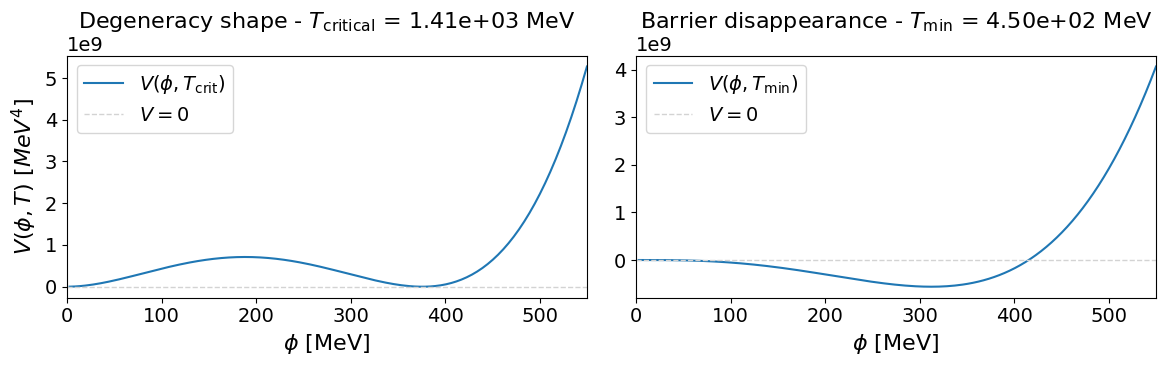

In [124]:
if T_max is not None: v_max = V(phi, T_max)
if T_min is not None: v_min = V(phi, T_min)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if T_max is not None:
    v_max = V(phi, T_max)
    axes[0].plot(phi, v_max, label = '$V(\phi, T_\\mathrm{{crit}})$')
    axes[0].set_title(f'Degeneracy shape - $T_{{\\mathrm{{critical}}}}$ = {T_max:.2e} {units}',fontsize=16)
    axes[0].set_xlim(phi[0], phi[-1])
    axes[0].set_ylabel(f"$V(\phi, T)$ $[{units}^{4}]$")

if T_min is not None:
    v_min = V(phi, T_min)
    axes[1].plot(phi, v_min, label= '$V(\phi, T_\\mathrm{{min}})$')
    axes[1].set_title(f'Barrier disappearance - $T_{{\\mathrm{{min}}}}$ = {T_min:.2e} {units}',fontsize=16)
    axes[1].set_xlim(phi[0], phi[-1])

for ax in axes:
    ax.set_xlabel(f"$\phi$ [{units}]")
    ax.axhline(false_min_tmax[1], color='lightgrey', linestyle='--', linewidth=1, label = "$V = 0$")
    ax.legend()

plt.tight_layout()
plt.show()

In [92]:
maxvev

np.float64(375.8197617664808)

In [93]:
import numpy as np
from espinosa import Vt_vec

def V_1d(phi, T):
    out = V(phi, T)
    a = np.asarray(out, dtype=float)
    return float(a) if a.ndim == 0 else a.reshape(-1)

def dV_1d(phi, T):
    out = dV(phi, T)
    a = np.asarray(out, dtype=float)
    return float(a) if a.ndim == 0 else a.reshape(-1)

true_vev = {}
false_vev = {}
S3overT = {}
V_min_value = {}
phi0_min = {}
V_exit = {}

def action_over_T(T, c_step_phi=1e-3, precision=1e-3):
    instance = Vt_vec(
        T, V_1d, dV_1d,
        step_phi=c_step_phi,
        precision=precision,
        vev0=maxvev,
        ratio_vev_step0=50
    )
    if instance.barrier:
        true_vev[T] = instance.true_min
        false_vev[T] = instance.phi_original_false_vev
        S3overT[T] = instance.action_over_T
        V_min_value[T] = instance.min_V
        phi0_min[T] = instance.phi0_min
        V_exit[T] = instance.V_exit
        return instance.action_over_T
    return None


In [94]:
import time

n_points = 100
temperatures = np.linspace(T_min, T_max, n_points)
action_vec = np.vectorize(action_over_T)

start_time = time.time()
action_vec(temperatures)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

temperatures = temperatures = np.array(sorted(S3overT.keys()))


Elapsed time: 7.92 seconds


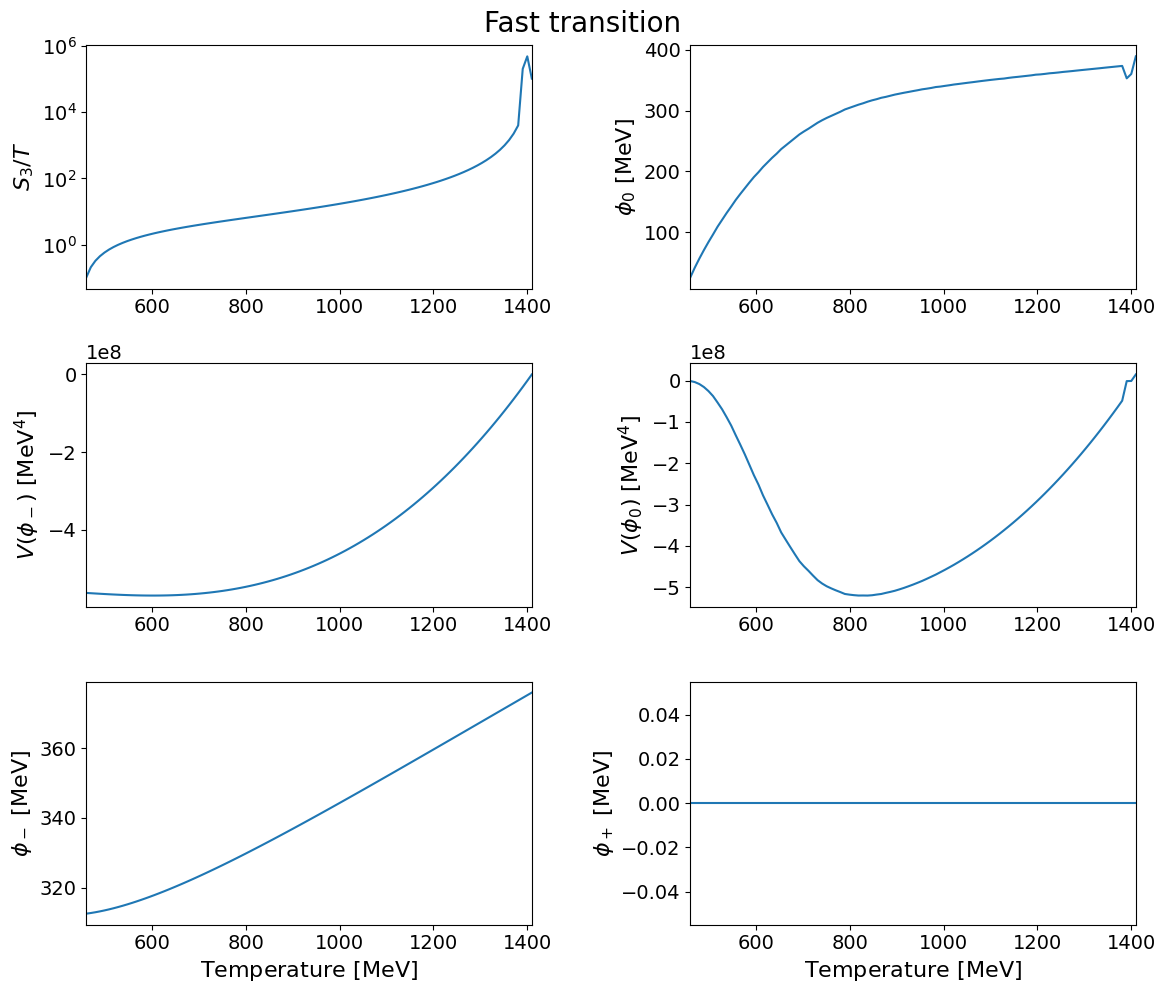

Minimum of the action at T = 4.60e+02 MeV


In [95]:
import matplotlib.pyplot as plt
from pathlib import Path

# Define the directory to save figures
figure_dir = "figures/"
Path(figure_dir).mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes[0, 0].plot(temperatures, [S3overT[T] for T in temperatures])
#axes[0, 0].set_title('$S_3/T$')
#axes[0, 0].set_xlabel(f"T [{units}]")
axes[0, 0].set_ylabel('$S_3/T$')
axes[0, 0].set_yscale('log')

axes[0, 1].plot(temperatures, [phi0_min[T] for T in temperatures])
#axes[0, 1].set_title('$\phi_{0,\mathrm{min}}$')
#axes[0, 1].set_xlabel(f"T [{units}]")
axes[0, 1].set_ylabel(f"$\phi_0\ \mathrm{{[{units}]}}$")

axes[1, 0].plot(temperatures, [V_min_value[T] for T in temperatures])
#axes[1, 0].set_title('V(true_vev)')
#axes[1, 0].set_xlabel(f"T [{units}]")
axes[1, 0].set_ylabel(f"$V(\phi_-)\ \mathrm{{[{units}^4]}}$")

axes[1, 1].plot(temperatures, [V_exit[T] for T in temperatures])
#axes[1, 1].set_title('$V(\phi_{0,\mathrm{min}})$')
#axes[1, 1].set_xlabel(f"T [{units}]")
axes[1, 1].set_ylabel(f"$V(\phi_0)\ \mathrm{{[{units}^4]}}$")

axes[2, 0].plot(temperatures, [true_vev[T] for T in temperatures])
#axes[2, 0].set_title('True vev')
axes[2, 0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 0].set_ylabel(f"$\phi_-\ \mathrm{{[{units}]}}$")

axes[2, 1].plot(temperatures, [false_vev[T] for T in temperatures])
#axes[2, 1].set_title('False vev')
axes[2, 1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 1].set_ylabel(f"$\phi_+\ \mathrm{{[{units}]}}$")

for ax in axes.flatten():
    ax.set_xlim(temperatures[0], temperatures[-1])

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.00)
plt.savefig(figure_dir + f"action_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Minimum of the action at T = {temperatures[np.argmin([S3overT[T] for T in temperatures])]:.2e} {units}")

In [96]:
import importlib, inspect
import numpy as np
import temperatures as temp

# 1) reset the module (undo previous monkey patches)
temp = importlib.reload(temp)

# 2) patch s_SM so it accepts `units=` (only if the real one doesn't)
_sig = inspect.signature(temp.s_SM)
if "units" not in _sig.parameters:
    _real_s_SM = temp.s_SM
    def s_SM(T, units=None):
        return _real_s_SM(T)
    temp.s_SM = s_SM

def _asfloat(x):
    return float(np.asarray(x, dtype=float).squeeze())

# 3) safe compute_logP_f (forces scalars/1D everywhere)
def compute_logP_f_safe(m, V_min_value, S3overT, v_w, units='GeV', cum_method='cumulative_simpson'):
    # choose cumulative integrator
    if cum_method == 'cumulative_simpson' and hasattr(temp, "cumulative_simpson"):
        cum_f = temp.cumulative_simpson
    else:
        from scipy.integrate import cumulative_trapezoid
        cum_f = cumulative_trapezoid

    V = m.Vtot

    Temps = np.array(sorted(set(V_min_value.keys()) & set(S3overT.keys())), dtype=float)
    if Temps.size < 2:
        return np.array([]), Temps, np.array([]), np.array([]), np.array([])

    steps = len(Temps)
    T_step = max((Temps[-1] - Temps[0]) * 1e-3, 1e-6)

    def finite_dVdT(phi, T, step=T_step):
        Tm = max(T - step, 0.0)
        Tp = T + step
        if Tm == T:
            val = (V(np.array([phi]), Tp) - V(np.array([phi]), T)) / step
        else:
            val = (V(np.array([phi]), Tp) - V(np.array([phi]), Tm)) / (Tp - Tm)
        return _asfloat(val) - temp.s_SM(T, units=units)

    def finite_d2VdT2(phi, T):
        step2 = 0.5 * T_step
        Tm = max(T - step2, 0.0)
        Tp = T + step2
        if Tm == T:
            Tpp = T + 2 * step2
            f0 = finite_dVdT(phi, T,  step2)
            f1 = finite_dVdT(phi, Tp, step2)
            f2 = finite_dVdT(phi, Tpp, step2)
            return (f2 - 2*f1 + f0) / (step2**2)
        f_plus  = finite_dVdT(phi, Tp, step2)
        f_minus = finite_dVdT(phi, Tm, step2)
        return (f_plus - f_minus) / (Tp - Tm)

    e_vacuum = np.array([-_asfloat(V_min_value[t]) for t in Temps], dtype=float)
    e_radiation = np.pi**2 * temp.g_rho(Temps / temp.convert_units[units]) * Temps**4 / 30.0
    H = np.sqrt((e_vacuum + e_radiation) / 3.0) / (temp.M_pl * temp.convert_units[units])

    S3_T = np.array([_asfloat(S3overT[t]) for t in Temps], dtype=float)
    Gamma = Temps**4 * (S3_T / (2*np.pi))**(3/2) * np.exp(-S3_T)

    ratio_V = np.array([finite_d2VdT2(0.0, T) / finite_dVdT(0.0, T) for T in Temps], dtype=float)

    logP_f = np.zeros_like(Temps, dtype=float)
    f_ext = ratio_V * Gamma / H

    # integrate
    for i in range(steps - 1):
        cum_ratio_V = cum_f(ratio_V[i:], x=Temps[i:], initial=0.0)

        f1 = ratio_V[i:] / H[i:] * np.exp(cum_ratio_V / 3.0)
        cum_f1 = cum_f(f1, x=Temps[i:], initial=0.0)

        f2 = f_ext[i:] * np.exp(-cum_ratio_V) * (cum_f1**3)
        cum_f2 = cum_f(f2, x=Temps[i:], initial=0.0)

        logP_f[i] = - (4.0/243.0) * np.pi * (v_w**3) * cum_f2[-1]

    return logP_f, Temps, ratio_V, Gamma, H

temp.compute_logP_f = compute_logP_f_safe

print("Patched: temperatures.s_SM and temperatures.compute_logP_f (safe).")


Patched: temperatures.s_SM and temperatures.compute_logP_f (safe).


In [97]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

import temperatures as temp
from dof_interpolation import g_rho
from utils import convert_units

def _crossing_linear(x, y, ystar):
    """
    Return x where y crosses ystar (linear interp). Assumes x increasing.
    Picks the first crossing from high-T side (largest x) going down in T if needed.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 2:
        return np.nan

    # find any sign change in (y-ystar)
    s = y - ystar
    idx = np.where(s[:-1] * s[1:] <= 0)[0]
    if idx.size == 0:
        return np.nan

    i = idx[0]
    x0, x1 = x[i], x[i+1]
    y0, y1 = y[i], y[i+1]
    if y1 == y0:
        return 0.5*(x0 + x1)
    return x0 + (ystar - y0) * (x1 - x0) / (y1 - y0)

def compute_logP_f_fixed(V_min_value, S3overT, *, v_w=1.0, units="MeV",
                         use_g_running=True, clip_exp=700.0):
    # Use only temps that exist in BOTH dicts
    Temps = np.array(sorted(set(V_min_value.keys()) & set(S3overT.keys())), dtype=float)
    if Temps.size < 3:
        raise RuntimeError("Need >=3 temperatures with both V_min_value and S3overT.")

    # Vacuum + radiation energy density -> H(T)
    e_vac = np.array([-V_min_value[T] for T in Temps], dtype=float)
    g = np.asarray(g_rho(Temps / convert_units[units]), dtype=float)
    e_rad = (np.pi**2 / 30.0) * g * Temps**4
    H = np.sqrt(np.maximum(e_vac + e_rad, 0.0) / 3.0) / (temp.M_pl * convert_units[units])

    # Nucleation rate prefactor
    S3_T = np.array([S3overT[T] for T in Temps], dtype=float)
    S3_clip = np.clip(S3_T, 0.0, clip_exp)  # stabilise exp(-S3/T)
    Gamma = Temps**4 * (np.maximum(S3_T, 0.0) / (2*np.pi))**1.5 * np.exp(-S3_clip)

    # ---- KEY FIX: ratio_V for radiation era (because your V dropped the constant T^4 term)
    if use_g_running:
        ln_g = np.log(np.maximum(g, 1e-300))
        dln_g_dT = np.gradient(ln_g, Temps)
        ratio_V = 3.0/Temps + dln_g_dT
    else:
        ratio_V = 3.0/Temps

    # Same structure as ELENA compute_logP_f
    logP_f = np.zeros_like(Temps)
    f_ext = ratio_V * Gamma / np.maximum(H, 1e-300)

    for i in range(len(Temps) - 1):
        Ts = Temps[i:]
        r  = ratio_V[i:]
        Hs = H[i:]
        fE = f_ext[i:]

        cum_r = cumulative_trapezoid(r, x=Ts, initial=0.0)

        f1 = r/np.maximum(Hs, 1e-300) * np.exp(cum_r/3.0)
        cum_f1 = cumulative_trapezoid(f1, x=Ts, initial=0.0)

        f2 = fE * np.exp(-cum_r) * cum_f1**3
        cum_f2 = cumulative_trapezoid(f2, x=Ts, initial=0.0)

        logP_f[i] = -(4.0/243.0) * np.pi * (v_w**3) * cum_f2[-1]

    return logP_f, Temps, ratio_V, Gamma, H

# ----------------------------
# RUN + milestones
# ----------------------------
logP_f, Temps, ratio_V, Gamma, H = compute_logP_f_fixed(
    V_min_value, S3overT, v_w=1.0, units=units, use_g_running=True
)

P_f = np.exp(np.clip(logP_f, -700.0, 0.0))  # physical volume fraction (0..1)
nH  = temp.N_bubblesH(Temps, Gamma, logP_f, H, ratio_V)

print(f"Temps range: {Temps[0]} → {Temps[-1]}   N={len(Temps)}")
print(f"ratio_V range: {np.nanmin(ratio_V)} → {np.nanmax(ratio_V)}")
print(f"logP_f range: {np.nanmin(logP_f)} → {np.nanmax(logP_f)}")
print(f"P_f range: {np.nanmin(P_f)} → {np.nanmax(P_f)}")
print(f"nH range: {np.nanmin(nH)} → {np.nanmax(nH)}")

T_nuc = _crossing_linear(Temps, nH, 1.0)
T_perc = _crossing_linear(Temps, P_f, 0.71)
T_completion = _crossing_linear(Temps, P_f, 0.01)

print(f"\nT_nuc = {T_nuc} {units}")
print(f"T_perc = {T_perc} {units}")
print(f"T_completion = {T_completion} {units}")

if np.isnan(T_nuc):
    print("Note: No nucleation found in this window (max(nH) < 1). Try extending the T scan.")
if np.isnan(T_perc):
    print("Note: P_f never reached 0.71 in this window.")
if np.isnan(T_completion):
    print("Note: P_f never reached 0.01 in this window.")


Temps range: 459.6810331254276 → 1410.0   N=99
ratio_V range: 0.0021279335123628096 → 0.00652752739792315
logP_f range: -2.1715444143669115e+45 → 0.0
P_f range: 9.85967654375977e-305 → 1.0
nH range: -0.0 → 8087103664.110502

T_nuc = 1243.635210782193 MeV
T_perc = 1218.1114215438556 MeV
T_completion = 1206.5136413828561 MeV


In [98]:
T_min

np.float64(449.98390081038093)

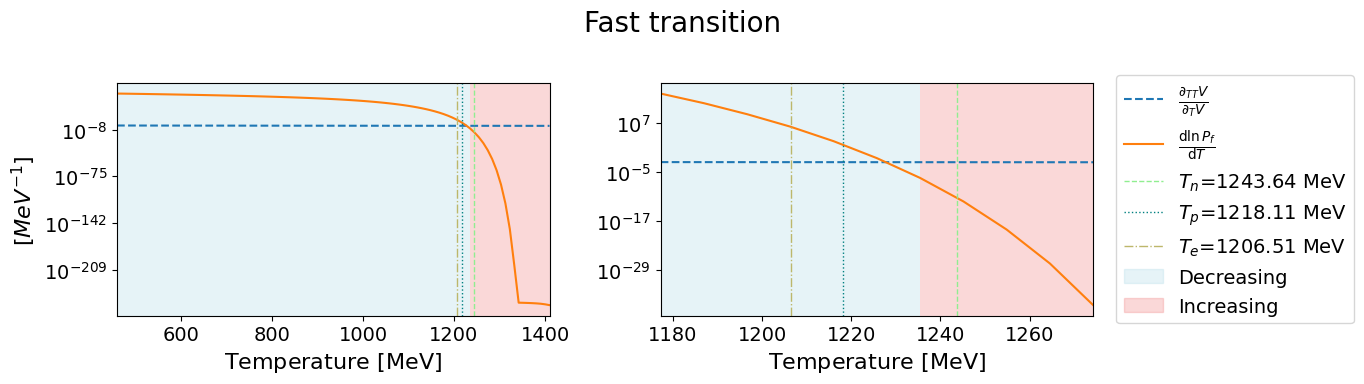

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---- required inputs assumed to exist ----
# Temps, ratio_V, logP_f, T_nuc, T_perc, T_completion, units

# optional labels/paths
description = globals().get("description", "3D DR")
figure_dir  = globals().get("figure_dir", "")

# ---- derivatives for plotting ----
d_dT_logP_f = np.gradient(logP_f, Temps)

# ---- plotting-safe versions (log-scale cannot show <=0) ----
floor = 1e-300
ratio_plot = np.clip(np.abs(ratio_V), floor, None)
dlogP_plot = np.clip(np.abs(d_dT_logP_f), floor, None)

# ---- zoom mask around milestones (for right panel) ----
t_mil_min = np.nanmin([T_completion, T_perc, T_nuc])
t_mil_max = np.nanmax([T_completion, T_perc, T_nuc])

i0 = max(int(np.argmin(np.abs(Temps - t_mil_min))) - 3, 0)
i1 = min(int(np.argmin(np.abs(Temps - t_mil_max))) + 3, len(Temps)-1)
mask = np.zeros_like(Temps, dtype=bool)
mask[i0:i1+1] = True

# ---- figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# left: full range
axes[0].plot(Temps, ratio_plot, label=r"$\frac{\partial_{TT}V}{\partial_T V}$", linestyle="--")
axes[0].plot(Temps, dlogP_plot, label=r"$$\frac{\mathrm{d}\ln P_f}{\mathrm{d}T}$")
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].set_ylabel(rf"$[{units}^{{-1}}]$")

# right: zoomed range
axes[1].plot(Temps[mask], ratio_plot[mask], label=r"$\frac{\partial_{TT}V}{\partial_T V}$", linestyle="--")
axes[1].plot(Temps[mask], dlogP_plot[mask], label=r"$\frac{\mathrm{d}\ln P_f}{\mathrm{d}T}$")
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

# legend patches for shading
decreasing_patch = mpatches.Patch(color="lightblue",  alpha=0.3, label="Decreasing")
increasing_patch = mpatches.Patch(color="lightcoral", alpha=0.3, label="Increasing")

for ax in axes:
    ax.set_yscale("log")
    ax.set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")

    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n$={T_nuc:.2f} {units}")
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p$={T_perc:.2f} {units}")
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e$={T_completion:.2f} {units}")

    # shading (use the SAME abs-comparison you’re plotting)
    for i in range(len(Temps) - 1):
        if dlogP_plot[i] >= ratio_plot[i]:
            ax.axvspan(Temps[i], Temps[i+1], facecolor="lightblue", alpha=0.3)
        else:
            ax.axvspan(Temps[i], Temps[i+1], facecolor="lightcoral", alpha=0.3)

# put a clean legend outside on the right
handles, labels = axes[1].get_legend_handles_labels()
handles += [decreasing_patch, increasing_patch]
labels  += [decreasing_patch.get_label(), increasing_patch.get_label()]
axes[1].legend(handles=handles, labels=labels, loc="center left", bbox_to_anchor=(1.03, 0.5))

fig.suptitle(f"{description} transition", y=0.98)
plt.tight_layout()
plt.savefig(figure_dir + f"volume_{description}.pdf", dpi=300, bbox_inches="tight")
plt.show()


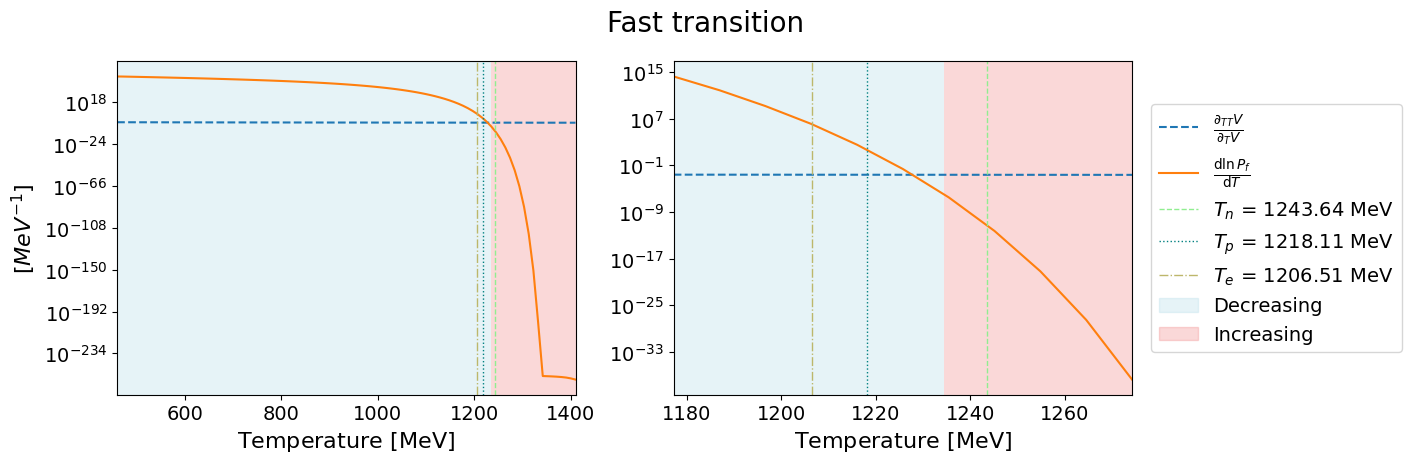

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# assumes you already have:
# Temps, ratio_V, logP_f, T_nuc, T_perc, T_completion, units, description, figure_dir
# and (optionally) mask

# ---------- derive d/dT log(P_f) ----------
d_dT_logP_f = np.gradient(logP_f, Temps)

# ---------- log-scale safe arrays (plotting only) ----------
ratio_plot = np.clip(np.asarray(ratio_V, float), 1e-300, None)
dlog_plot  = np.clip(np.asarray(d_dT_logP_f, float), 1e-300, None)

# ---------- define zoom mask if not present / too small ----------
if "mask" not in globals() or np.sum(mask) < 3:
    t_lo = np.nanmin([T_completion, T_perc, T_nuc])
    t_hi = np.nanmax([T_completion, T_perc, T_nuc])
    mask = (Temps >= t_lo) & (Temps <= t_hi)
    if np.sum(mask) < 3:
        mask = np.ones_like(Temps, dtype=bool)

# ---------- intersections between (d/dT logP_f) and (ratio_V) ----------
diff = np.asarray(d_dT_logP_f, float) - np.asarray(ratio_V, float)
finite = np.isfinite(Temps) & np.isfinite(diff)
T_f = Temps[finite]
d_f = diff[finite]

intersections = []
for i in range(len(T_f) - 1):
    y1, y2 = d_f[i], d_f[i + 1]
    if y1 == 0.0:
        intersections.append(float(T_f[i]))
    if y1 * y2 < 0.0:
        x1, x2 = T_f[i], T_f[i + 1]
        # linear root of y(x)=0
        intersections.append(float(x1 - y1 * (x2 - x1) / (y2 - y1)))

# points for precise shading
all_points = np.unique(np.clip(np.concatenate([Temps, intersections]), Temps.min(), Temps.max()))
all_points.sort()

# ---------- plot ----------
os.makedirs(figure_dir, exist_ok=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

# full panel
axes[0].plot(Temps, ratio_plot, label=r"$V_{TT}/V_T$", linestyle="--")
axes[0].plot(Temps, dlog_plot,  label=r"$\mathrm{d}\ln P_f/\mathrm{d}T$")
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].set_ylabel(rf"$[{units}^{{-1}}]$")

# zoom panel
axes[1].plot(Temps[mask], ratio_plot[mask], label=r"$\frac{\partial_{TT}V}{\partial_T V}$", linestyle="--")
axes[1].plot(Temps[mask], dlog_plot[mask],  label=r"$\frac{\mathrm{d}\ln P_f}{\mathrm{d}T}$")
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

# legend patches
decreasing_patch = mpatches.Patch(color="lightblue",  alpha=0.3, label="Decreasing")
increasing_patch = mpatches.Patch(color="lightcoral", alpha=0.3, label="Increasing")

for ax in axes:
    ax.set_yscale("log")
    ax.set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")

    # milestone lines (keep labels only once per axis)
    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n$ = {T_nuc:.2f} {units}")
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p$ = {T_perc:.2f} {units}")
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e$ = {T_completion:.2f} {units}")

    # background shading with intersection-refined bins
    for i in range(len(all_points) - 1):
        a, b = all_points[i], all_points[i + 1]
        mid = 0.5 * (a + b)
        d_mid = np.interp(mid, Temps, d_dT_logP_f)
        r_mid = np.interp(mid, Temps, ratio_V)

        if np.isfinite(d_mid) and np.isfinite(r_mid):
            if d_mid >= r_mid:
                ax.axvspan(a, b, facecolor="lightblue",  alpha=0.3)
            else:
                ax.axvspan(a, b, facecolor="lightcoral", alpha=0.3)

# put legend outside on the right panel
handles, labels = axes[1].get_legend_handles_labels()
handles += [decreasing_patch, increasing_patch]
labels  += ["Decreasing", "Increasing"]
axes[1].legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.suptitle(f"{description} transition", y=1.12)
plt.savefig(os.path.join(figure_dir, f"volume_{description}.pdf"), dpi=300, bbox_inches="tight")
plt.show()


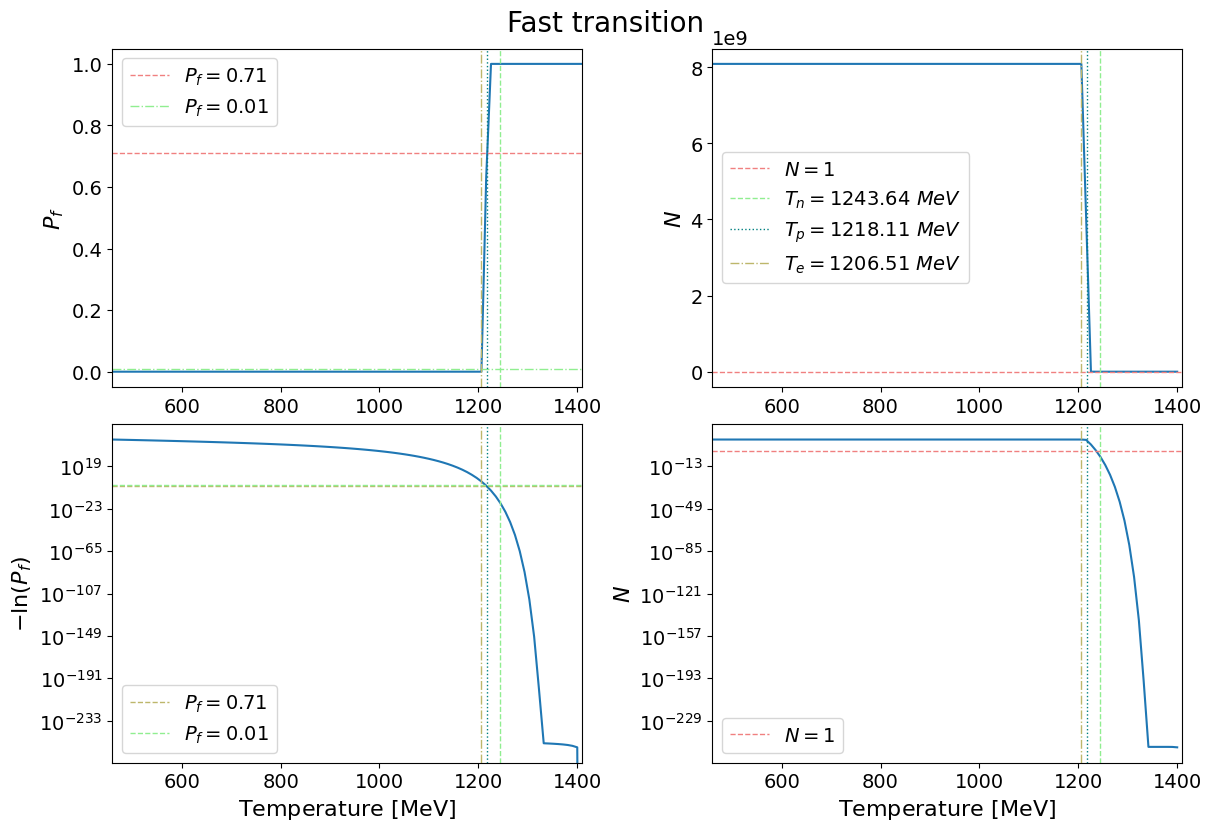

Average number of bubbles at lowest valid T, N = 8.087e+09


In [111]:
import numpy as np
import matplotlib.pyplot as plt
import os

# assumes you already have:
# Temps, logP_f, nH, T_nuc, T_perc, T_completion, units, description, figure_dir

os.makedirs(figure_dir, exist_ok=True)

# plotting-safe Pf (avoid underflow to 0 for the first panel if you want)
Pf = np.exp(np.clip(logP_f, -700.0, 0.0))

mask_nH = np.isfinite(nH) & (nH > 0)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# --- Pf linear ---
axes[0,0].plot(Temps, Pf)
axes[0,0].set_ylabel(r"$P_f$")
axes[0,0].axhline(0.71, color="lightcoral", linestyle="--", linewidth=1, label=r"$P_f=0.71$")
axes[0,0].axhline(0.01, color="lightgreen", linestyle="-.", linewidth=1, label=r"$P_f=0.01$")
axes[0,0].legend()

# --- N linear ---
axes[0,1].plot(Temps[mask_nH], nH[mask_nH])
axes[0,1].axhline(1, color="lightcoral", linestyle="--", linewidth=1, label=r"$N=1$")
axes[0,1].set_ylabel(r"$N$")
axes[0,1].legend()

# --- -log Pf (log y) ---
axes[1,0].plot(Temps, -logP_f)
axes[1,0].axhline(-np.log(0.71), color="darkkhaki", linestyle="--", linewidth=1, label=r"$P_f=0.71$")
axes[1,0].axhline(-np.log(0.01), color="lightgreen", linestyle="--", linewidth=1, label=r"$P_f=0.01$")
axes[1,0].set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,0].set_ylabel(r"$-\ln(P_f)$")
axes[1,0].set_yscale("log")
axes[1,0].legend()

# --- N (log y) ---
axes[1,1].plot(Temps[mask_nH], nH[mask_nH])
axes[1,1].axhline(1, color="lightcoral", linestyle="--", linewidth=1, label=r"$N=1$")
axes[1,1].set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,1].set_ylabel(r"$N$")
axes[1,1].set_yscale("log")
axes[1,1].legend()

# --- milestones: add lines without duplicating legend entries ---
for ax in axes.flatten():
    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1)
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1)
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1)
    ax.set_xlim(Temps[0], Temps[-1])

# add a single milestone legend on the top-right panel (cleaner)
milestone_handles = [
    plt.Line2D([0],[0], color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n={T_nuc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p={T_perc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e={T_completion:.2f}\ {units}$"),
]
axes[0,1].legend(handles=axes[0,1].get_legend_handles_labels()[0] + milestone_handles,
                 labels=axes[0,1].get_legend_handles_labels()[1] + [h.get_label() for h in milestone_handles],
                 loc="best")

fig.suptitle(f"{description} transition", y=1.02)
plt.savefig(os.path.join(figure_dir, f"evolution_{description}.pdf"), dpi=300, bbox_inches="tight")
plt.show()

if np.any(mask_nH):
    print(f"Average number of bubbles at lowest valid T, N = {nH[mask_nH][0]:.3e}")
else:
    print("No valid nH>0 points to report.")


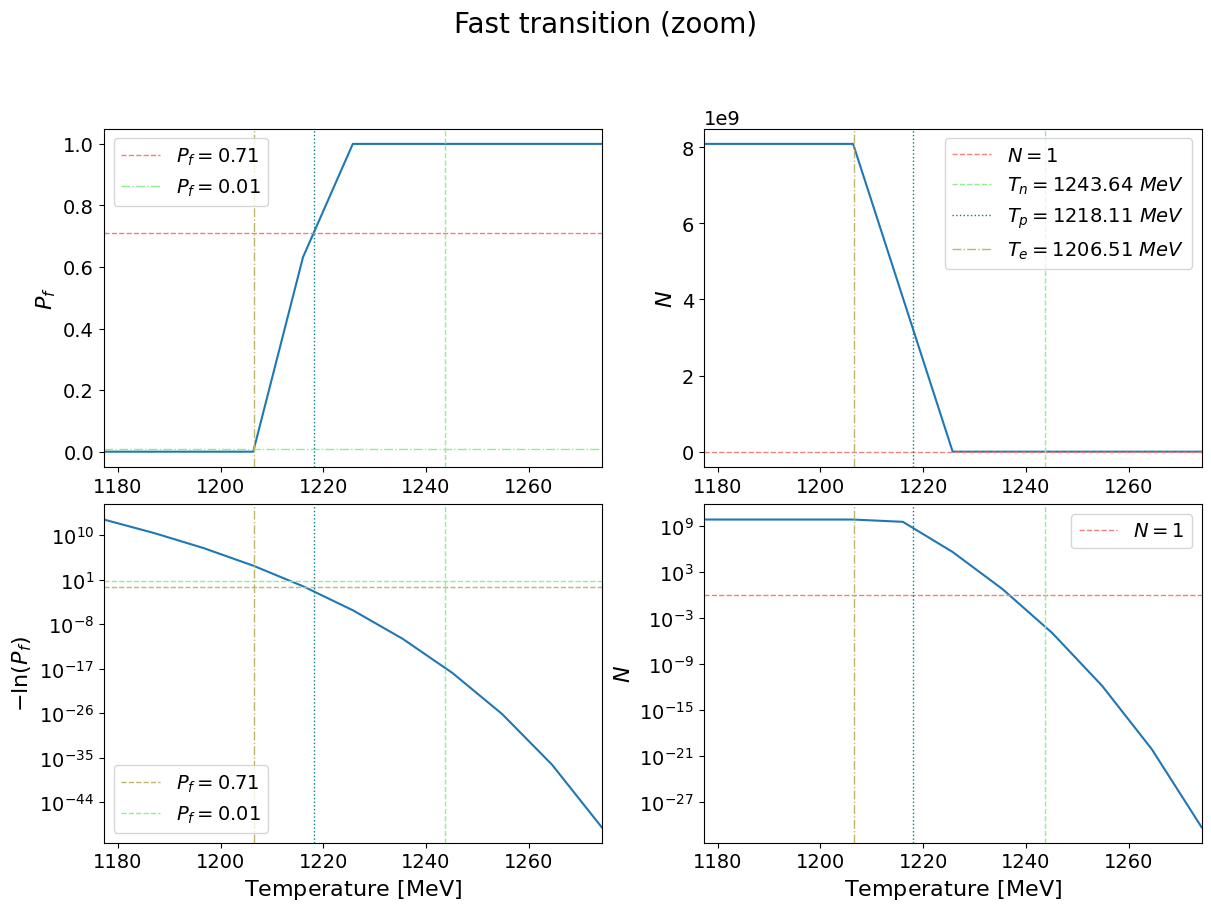

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import os

# assumes you already have:
# Temps, logP_f, nH, mask, T_nuc, T_perc, T_completion, units, description, figure_dir

os.makedirs(figure_dir, exist_ok=True)

# zoom arrays
Tz = Temps[mask]
logPz = logP_f[mask]
nHz = nH[mask]

# plotting-safe Pf
Pfz = np.exp(np.clip(logPz, -700.0, 0.0))

# for log-plot of N: keep only positive finite values
mask_nH_pos = np.isfinite(nHz) & (nHz > 0)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# Pf (linear)
axes[0,0].plot(Tz, Pfz)
axes[0,0].set_ylabel(r"$P_f$")
axes[0,0].axhline(0.71, color="lightcoral", linestyle="--", linewidth=1, label=r"$P_f=0.71$")
axes[0,0].axhline(0.01, color="lightgreen", linestyle="-.", linewidth=1, label=r"$P_f=0.01$")
axes[0,0].legend()

# N (linear)
axes[0,1].plot(Tz, nHz)
axes[0,1].axhline(1, color="lightcoral", linestyle="--", linewidth=1, label=r"$N=1$")
axes[0,1].set_ylabel(r"$N$")
axes[0,1].legend()

# -log Pf (log y)
axes[1,0].plot(Tz, -logPz)
axes[1,0].axhline(-np.log(0.71), color="darkkhaki", linestyle="--", linewidth=1, label=r"$P_f=0.71$")
axes[1,0].axhline(-np.log(0.01), color="lightgreen", linestyle="--", linewidth=1, label=r"$P_f=0.01$")
axes[1,0].set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,0].set_ylabel(r"$-\ln(P_f)$")
axes[1,0].set_yscale("log")
axes[1,0].legend()

# N (log y) – use positive points only
axes[1,1].plot(Tz[mask_nH_pos], nHz[mask_nH_pos])
axes[1,1].axhline(1, color="lightcoral", linestyle="--", linewidth=1, label=r"$N=1$")
axes[1,1].set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,1].set_ylabel(r"$N$")
axes[1,1].set_yscale("log")
axes[1,1].legend()

# milestone vertical lines (avoid duplicating legend spam)
for ax in axes.flatten():
    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1)
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1)
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1)
    ax.set_xlim(Tz[0], Tz[-1])

# add one milestone legend (clean) in top-right panel
milestone_handles = [
    plt.Line2D([0],[0], color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n={T_nuc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p={T_perc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e={T_completion:.2f}\ {units}$"),
]
h0, l0 = axes[0,1].get_legend_handles_labels()
axes[0,1].legend(h0 + milestone_handles, l0 + [h.get_label() for h in milestone_handles], loc="best")

fig.suptitle(f"{description} transition (zoom)", y=1.12)
plt.savefig(os.path.join(figure_dir, f"evolution_{description}_zoom.pdf"), dpi=300, bbox_inches="tight")
plt.show()


/tmp/ipython-input-3915825340.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[i] = d[T]


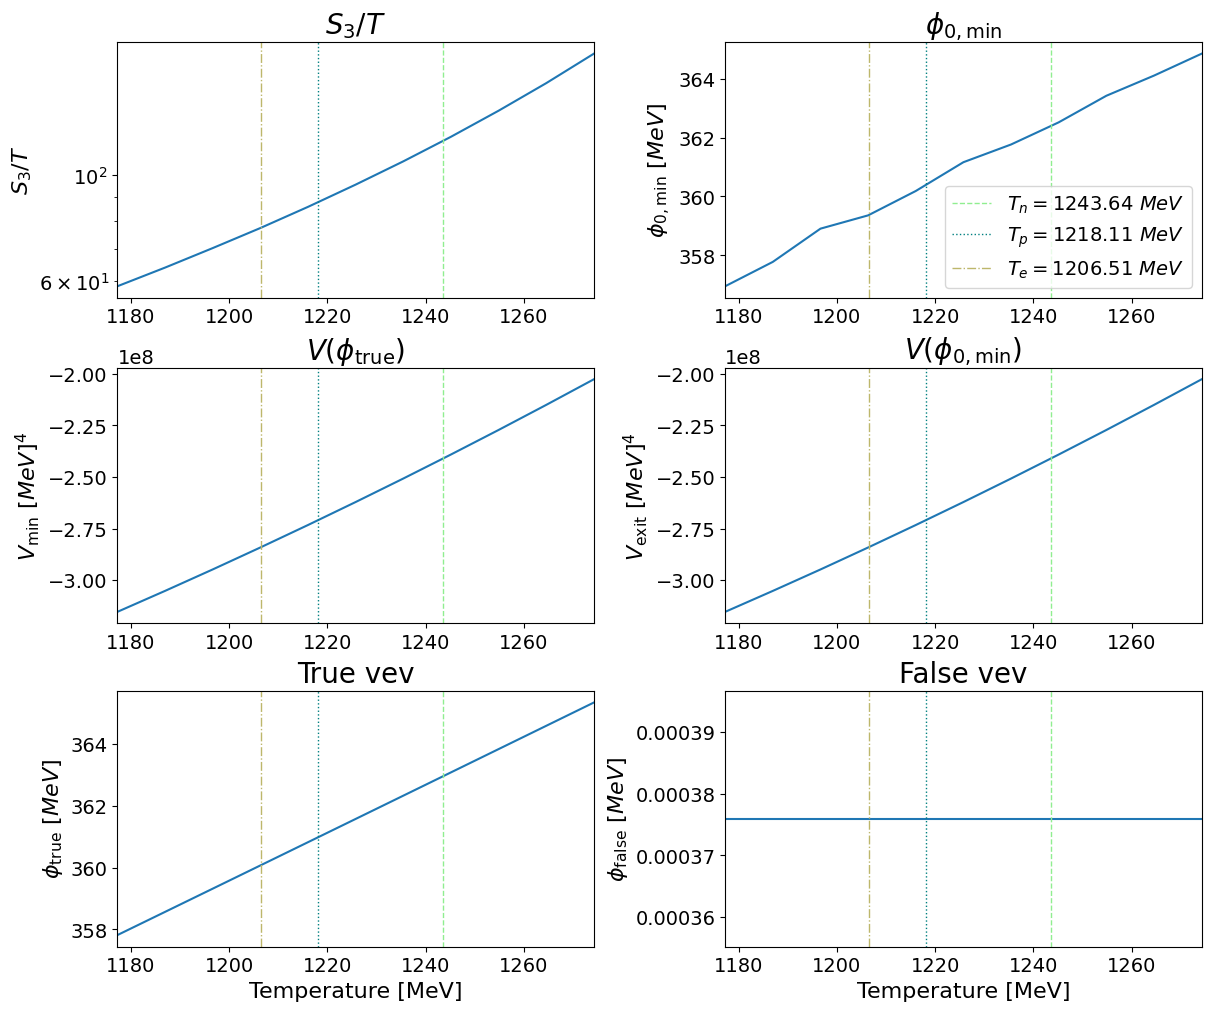

In [115]:
import numpy as np
import matplotlib.pyplot as plt

# assumes you already have:
# Temps, mask, units, T_nuc, T_perc, T_completion
# dicts: S3overT, phi0_min, V_min_value, V_exit, true_vev, false_vev

Tz = np.asarray(Temps[mask], float)

def vec_from_dict(d, Tgrid):
    out = np.full_like(Tgrid, np.nan, dtype=float)
    for i, T in enumerate(Tgrid):
        # keys are floats; try exact then nearest fallback
        if T in d:
            out[i] = d[T]
        else:
            # nearest key fallback (safe for float rounding issues)
            ks = np.asarray(list(d.keys()), float)
            j = int(np.argmin(np.abs(ks - T)))
            out[i] = d[float(ks[j])]
    return out

S3z   = vec_from_dict(S3overT,    Tz)
phi0z = vec_from_dict(phi0_min,   Tz)
Vminz = vec_from_dict(V_min_value,Tz)
Vexz  = vec_from_dict(V_exit,     Tz)
phit  = vec_from_dict(true_vev,   Tz)
phif  = vec_from_dict(false_vev,  Tz)

fig, axes = plt.subplots(3, 2, figsize=(12, 10), constrained_layout=True)

axes[0,0].plot(Tz, np.clip(S3z, 1e-300, None))
axes[0,0].set_title(r"$S_3/T$")
axes[0,0].set_ylabel(r"$S_3/T$")
axes[0,0].set_yscale("log")

axes[0,1].plot(Tz, phi0z)
axes[0,1].set_title(r"$\phi_{0,\mathrm{min}}$")
axes[0,1].set_ylabel(rf"$\phi_{{0,\mathrm{{min}}}}\ [{units}]$")

axes[1,0].plot(Tz, Vminz)
axes[1,0].set_title(r"$V(\phi_{\rm true})$")
axes[1,0].set_ylabel(rf"$V_{{\mathrm{{min}}}}\ [{units}]^4$")

axes[1,1].plot(Tz, Vexz)
axes[1,1].set_title(r"$V(\phi_{0,\mathrm{min}})$")
axes[1,1].set_ylabel(rf"$V_{{\mathrm{{exit}}}}\ [{units}]^4$")

axes[2,0].plot(Tz, phit)
axes[2,0].set_title("True vev")
axes[2,0].set_xlabel(rf"Temperature [{units}]")
axes[2,0].set_ylabel(rf"$\phi_{{\mathrm{{true}}}}\ [{units}]$")

axes[2,1].plot(Tz, phif)
axes[2,1].set_title("False vev")
axes[2,1].set_xlabel(rf"Temperature [{units}]")
axes[2,1].set_ylabel(rf"$\phi_{{\mathrm{{false}}}}\ [{units}]$")

# milestone handles (single clean legend style)
milestone_handles = [
    plt.Line2D([0],[0], color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n={T_nuc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p={T_perc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e={T_completion:.2f}\ {units}$"),
]

for ax in axes.flatten():
    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1)
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1)
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1)
    ax.set_xlim(Tz[0], Tz[-1])

# put the milestone legend once (top-right panel)
axes[0,1].legend(handles=milestone_handles, loc="best")

plt.show()


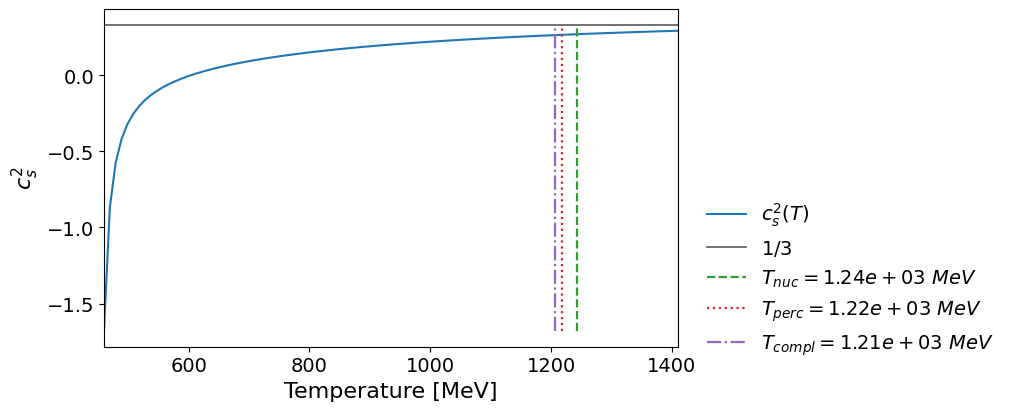

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from GWparams import cs2

# ---- patch dp so GWparams.cs2 can call the potential ----
def _ensure_dp_has_V(dp, V, dV):
    if (not hasattr(dp, "V")) or (not callable(getattr(dp, "V", None))):
        dp.V = lambda phi, T: V(np.asarray(phi, float), float(T))
    if (not hasattr(dp, "Vtot")) or (not callable(getattr(dp, "Vtot", None))):
        dp.Vtot = dp.V
    if (not hasattr(dp, "gradV")) or (not callable(getattr(dp, "gradV", None))):
        dp.gradV = lambda phi, T: dV(np.asarray(phi, float), float(T))

_ensure_dp_has_V(dp, V, dV)

Temps = np.asarray(Temps, float)

def cs2_safe(T):
    T = float(T)
    try:
        return float(cs2(T, dp, true_vev, units=units))
    except TypeError:
        return float(cs2(T, dp, true_vev))
    except Exception:
        return np.nan

y = np.array([cs2_safe(T) for T in Temps], dtype=float)

ymin = np.nanmin(y)
ymax = np.nanmax(y)
ymax = np.nanmax([ymax, (1 + 1e-4) / 3])

fig, ax = plt.subplots(figsize=(10, 4.0), constrained_layout=True)

# main curve + reference line
ax.plot(Temps, y, label=r"$c_s^2(T)$", color="C0")
ax.axhline(1/3, color="0.35", linestyle="-", linewidth=1.2, label=r"$1/3$")

def vline(T, color, ls, lab):
    if T is not None and np.isfinite(T):
        ax.vlines(T, ymin, ymax, color=color, linestyle=ls, linewidth=1.6, label=lab)

vline(T_nuc,        "C2", "--", rf"$T_{{nuc}}={T_nuc:.2e}\ {units}$")
vline(T_perc,       "C3", ":",  rf"$T_{{perc}}={T_perc:.2e}\ {units}$")
vline(T_completion, "C4", "-.", rf"$T_{{compl}}={T_completion:.2e}\ {units}$")

ax.set_xlabel(rf"Temperature [{units}]")
ax.set_ylabel(r"$c_s^2$")
ax.set_xlim(Temps[0], Temps[-1])

# legend outside (right)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.2), frameon=False)

plt.show()


In [118]:
from GWparams import alpha_th_bar # This is the definition of \alpha

def c_alpha_inf(T, units):
    v_true = true_vev[T]
    v_false = false_vev[T]
    Dm2_photon = 3 * g**2 * (v_true**2 - v_false**2)
    Dm2_scalar = 3 * lambda_ * (v_true**2 - v_false**2)
    numerator = (Dm2_photon + Dm2_scalar) * T**2 / 24
    rho_tot = - T * 3 * (dp.dVdT(v_false, T, include_radiation=True, include_SM = True, units = units) ) / 4
    rho_DS = - T * 3 * (dp.dVdT(v_false, T, include_radiation=True, include_SM = False, units = units) ) / 4
    return numerator/ rho_tot, numerator / rho_DS

def c_alpha_eq(T, units):
    v_true = true_vev[T]
    v_false = false_vev[T]
    numerator = (g**2 * 3 * (g * (v_true - v_false)) * T**3)
    rho_tot = - T * 3 * (dp.dVdT(v_false, T, include_radiation=True, include_SM = True, units = units) ) / 4
    rho_DS = - T * 3 * (dp.dVdT(v_false, T, include_radiation=True, include_SM = False, units = units) ) / 4
    return numerator / rho_tot, numerator / rho_DS

In [119]:
import numpy as np
from types import MethodType

# pick a small floor relative to your scale (tweak if you want)
_phi_scale = max(1.0, float(np.nanmax(list(true_vev.values()))))
phi_eps = 1e-6 * _phi_scale   # try 1e-6–1e-4; smaller is "more limit-like" but can be noisier

def _phi_safe(phi):
    phi = float(np.squeeze(phi))
    return phi_eps if abs(phi) < phi_eps else phi

# --- wrap vev dicts so GWparams sees safe values when indexing at T ---
class NearestKeyDict(dict):
    def __getitem__(self, k):
        k = float(k)
        if dict.__contains__(self, k):
            return dict.__getitem__(self, k)
        ks = np.asarray(list(self.keys()), dtype=float)
        j = int(np.argmin(np.abs(ks - k)))
        return dict.__getitem__(self, float(ks[j]))

class SafePhiDict(NearestKeyDict):
    def __getitem__(self, k):
        return _phi_safe(super().__getitem__(k))

V_min_value = NearestKeyDict(V_min_value)
true_vev    = NearestKeyDict(true_vev)
false_vev   = SafePhiDict(false_vev)   # <-- key change

# --- safe call to dp potential ---
def _V_call(self, phi, T):
    phi = _phi_safe(phi)
    T = float(T)
    if hasattr(self, "Vtot"):
        return float(np.squeeze(self.Vtot(np.array([phi], float), T)))
    if hasattr(self, "V"):
        return float(np.squeeze(self.V(np.array([phi], float), T)))
    raise AttributeError("dp has neither Vtot nor V")

# --- adaptive T-derivatives (now with phi_safe inside) ---
def _dVdT(self, phi, T, include_radiation=True, include_SM=True, units="MeV",
          step_rel=1e-4, step_abs=1e-3, max_tries=10):
    phi = _phi_safe(phi)
    T   = float(T)
    h = max(step_abs, step_rel * max(1.0, abs(T)))
    for _ in range(max_tries):
        Tp = T + h
        Tm = max(T - h, 0.0)
        Vp = _V_call(self, phi, Tp)
        if Tm == T:
            V0 = _V_call(self, phi, T)
            dV = (Vp - V0) / (Tp - T)
        else:
            Vm = _V_call(self, phi, Tm)
            dV = (Vp - Vm) / (Tp - Tm)
        if np.isfinite(dV):
            return float(dV)
        h *= 0.2
    return float("nan")

def _d2VdT2(self, phi, T, include_radiation=True, include_SM=True, units="MeV",
           step_rel=1e-4, step_abs=1e-3, max_tries=10):
    phi = _phi_safe(phi)
    T   = float(T)
    h = max(step_abs, step_rel * max(1.0, abs(T)))
    for _ in range(max_tries):
        Tp = T + h
        Tm = max(T - h, 0.0)
        V0 = _V_call(self, phi, T)
        Vp = _V_call(self, phi, Tp)
        if Tm == T:
            Vpp = _V_call(self, phi, T + 2.0*h)
            d2V = (Vpp - 2.0*Vp + V0) / (h*h)
        else:
            Vm = _V_call(self, phi, Tm)
            d2V = (Vp - 2.0*V0 + Vm) / (h*h)
        if np.isfinite(d2V):
            return float(d2V)
        h *= 0.2
    return float("nan")

dp.dVdT   = MethodType(_dVdT, dp)
dp.d2VdT2 = MethodType(_d2VdT2, dp)

print("Using phi_eps =", phi_eps)
print("false_vev(T_perc) used =", false_vev[T_perc])
print("dVdT(false) =", dp.dVdT(false_vev[T_perc], T_perc, units=units))
print("d2VdT2(false) =", dp.d2VdT2(false_vev[T_perc], T_perc, units=units))


Using phi_eps = 0.0003759135773916135
false_vev(T_perc) used = 0.0003759135773916135
dVdT(false) = -4767.866086811584
d2VdT2(false) = -3.189594977206684


In [120]:
from GWparams import alpha_th_bar

alpha, alpha_DS = alpha_th_bar(T_perc, dp, V_min_value, false_vev, true_vev, units=units)
print(alpha, alpha_DS)


153.5709966438159 153.5709966438159


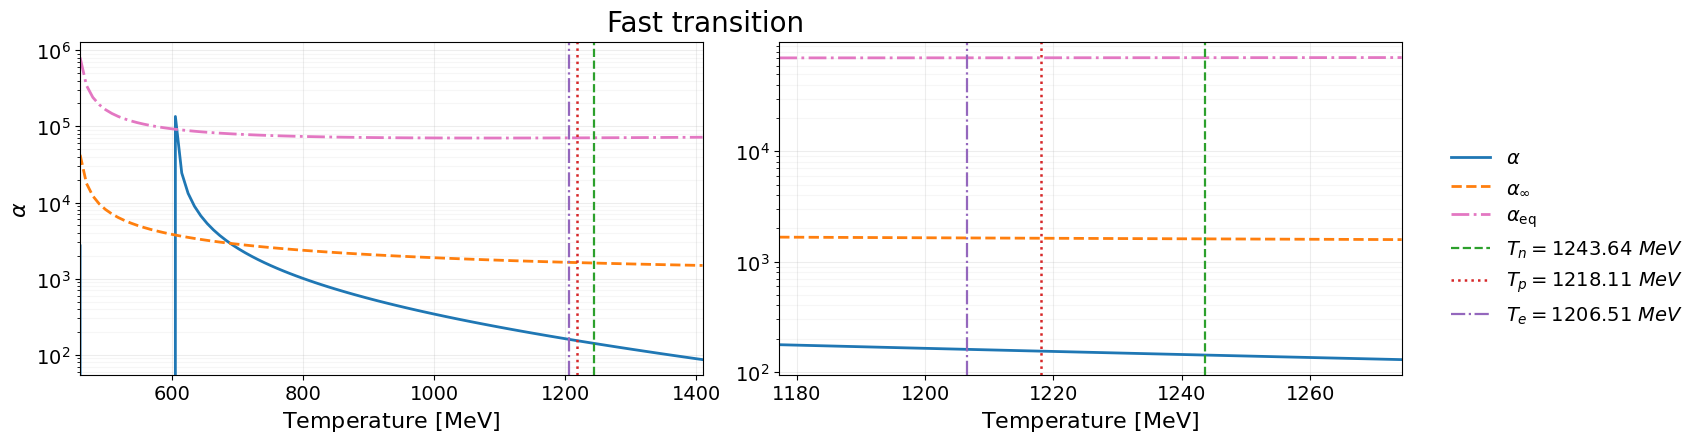

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from GWparams import alpha_th_bar

# --- helpers: float-key safe dict access ---
class NearestKeyDict(dict):
    def __getitem__(self, k):
        k = float(k)
        if dict.__contains__(self, k):
            return dict.__getitem__(self, k)
        ks = np.asarray(list(self.keys()), dtype=float)
        j = int(np.argmin(np.abs(ks - k)))
        return dict.__getitem__(self, float(ks[j]))

V_min_value = NearestKeyDict(V_min_value)
true_vev    = NearestKeyDict(true_vev)
false_vev   = NearestKeyDict(false_vev)

# --- safe wrappers ---
def alpha_safe(T):
    try:
        a, _ = alpha_th_bar(float(T), dp, V_min_value, false_vev, true_vev, units=units)
        return float(a)
    except Exception:
        return np.nan

def alpha_inf_safe(T):
    try:
        return float(c_alpha_inf(float(T), units)[0])
    except Exception:
        return np.nan

def alpha_eq_safe(T):
    try:
        return float(c_alpha_eq(float(T), units)[0])
    except Exception:
        return np.nan

Temps = np.asarray(Temps, float)

alpha_T     = np.array([alpha_safe(T)     for T in Temps], dtype=float)
alpha_inf_T = np.array([alpha_inf_safe(T) for T in Temps], dtype=float)
alpha_eq_T  = np.array([alpha_eq_safe(T)  for T in Temps], dtype=float)

# --- plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

# styles (consistent across both panels)
styles = {
    "alpha":     dict(color="C0", ls="-",  lw=2.0),
    "alpha_inf": dict(color="C1", ls="--", lw=2.0),
    "alpha_eq":  dict(color="C6", ls="-.", lw=2.0),
}
milestones = [
    ("T_n", T_nuc,        dict(color="C2", ls="--", lw=1.6)),
    ("T_p", T_perc,       dict(color="C3", ls=":",  lw=1.8)),
    ("T_e", T_completion, dict(color="C4", ls="-.", lw=1.6)),
]

def add_panel(ax, x, a, ai, ae, xlabel=True, ylabel=False, title=None, xlim=None):
    h1, = ax.plot(x, a,  label=r"$\alpha$",          **styles["alpha"])
    h2, = ax.plot(x, ai, label=r"$\alpha_\infty$",   **styles["alpha_inf"])
    h3, = ax.plot(x, ae, label=r"$\alpha_{\rm eq}$", **styles["alpha_eq"])

    # milestone lines (keep handles for the global legend)
    mhandles = []
    for lab, Tm, st in milestones:
        if Tm is not None and np.isfinite(Tm):
            mh = ax.axvline(Tm, label=rf"${lab}={Tm:.2f}\ {units}$", **st)
            mhandles.append(mh)

    ax.set_yscale("log")
    if xlabel:
        ax.set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")
    if ylabel:
        ax.set_ylabel(r"$\alpha$")
    if title:
        ax.set_title(title)
    if xlim is not None:
        ax.set_xlim(float(xlim[0]), float(xlim[1]))
    ax.grid(True, which="major", alpha=0.22)
    ax.grid(True, which="minor", alpha=0.10)

    return [h1, h2, h3] + mhandles

# left: full
handles_left = add_panel(
    axes[0],
    Temps, alpha_T, alpha_inf_T, alpha_eq_T,
    ylabel=True,
    title=None,
    xlim=(Temps[0], Temps[-1]),
)

# right: zoom
x_zoom = Temps[mask]
handles_right = add_panel(
    axes[1],
    x_zoom, alpha_T[mask], alpha_inf_T[mask], alpha_eq_T[mask],
    ylabel=False,
    title=None,
    xlim=(x_zoom[0], x_zoom[-1]),
)

# reduce x tick congestion on right panel
axes[1].xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
axes[1].xaxis.set_minor_locator(mticker.NullLocator())

# --- ONE legend for the whole figure (outside, right) ---
# Build legend handles/labels from left panel only (avoids duplicates)
h, l = axes[0].get_legend_handles_labels()

# keep unique labels in order
seen = set()
h_u, l_u = [], []
for hh, ll in zip(h, l):
    if ll not in seen:
        seen.add(ll)
        h_u.append(hh)
        l_u.append(ll)

fig.legend(
    h_u, l_u,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

fig.suptitle(f"{description} transition", y=1.07)
plt.savefig(figure_dir + f"alpha_{description}.pdf", dpi=300, bbox_inches="tight")
plt.show()
